In [1]:
# process_image.ipynb
# Created 2-10-20 by Eric Graves
# Process an image to "skullphone-ize" it.

In [63]:
# Imports and environment setup
#import opencv
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image

%matplotlib inline

# DEBUG shows input and output images, DEBUG_VERBOSE shows images and sizes at each step
DEBUG = True

# This parameter sets how much the image is scaled before processing: 
#-- Smaller image ==> more loss, but faster processing
#-- Just divides the image dimensions in pixels, good values are between 1 and 10. Any smaller and there is a lot of loss of detail/accent colors.
IMAGE_SCALE = 15 
    
# The number of clusters for k-means image color processing
NUM_CLUSTERS = 5
    
# Single test image name
TEST_IMAGE = 'IMG_3723_ART.PNG'# Brockhampton Saturation III album art

IMAGE_SCALE = 20

RGBA
(29, 29, 4)


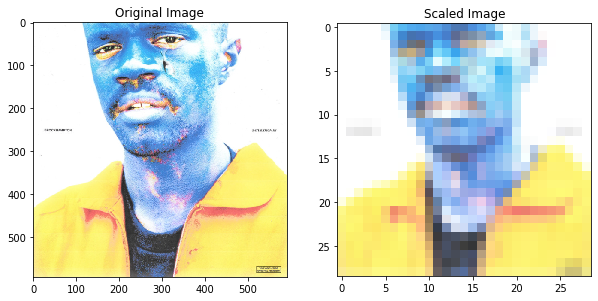

RGB


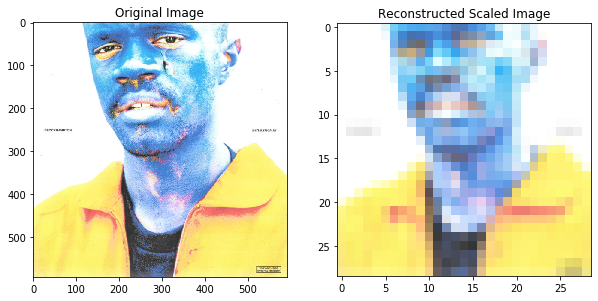

In [65]:
# Read image, set size
img = plt.imread(TEST_IMAGE, 0)
img_PIL = Image.open(TEST_IMAGE) # image opened in RGBA format: size=(x, y, 4[RGBA]) 
h,w = img.shape[:2]

# Resize image
img_resized = img_PIL.resize(((int)(h/IMAGE_SCALE), (int)(w/IMAGE_SCALE)))
img_rs_px = np.array(img_resized) # as numpy array
h_rs, w_rs = img_rs_px.shape[:2]

# Show the original and scaled images
if DEBUG:
    print(img_PIL.mode)
    print(img_rs_px.shape)
    fig = plt.figure(figsize = (10,20))
    p_orig = fig.add_subplot(2,2,1)
    p_orig.set_title("Original Image")
    plt.imshow(img) 
    p_scaled = fig.add_subplot(2,2,2)
    p_scaled.set_title("Scaled Image")
    plt.imshow(img_resized) 
    plt.show()
    
# Allocate output array
img_rgb = np.empty((h_rs, w_rs, 3), dtype=np.uint8)

# TODO: decide if a FSCS on the image would be useful. It may make the image more clear, but at the same time 
#       expose unnatural features.

row_index = -1

# For each pixel in the image
for row in img_rs_px:
    row_index +=1
    px_index = -1
    for px in row:
        px_index +=1
        # Extract color values
        (r, g, b) = px[:3]
        
        # Append to output array
        img_rgb[row_index, px_index, 0] = r
        img_rgb[row_index, px_index, 1] = g
        img_rgb[row_index, px_index, 2] = b # there is probably a better way to do this with np.concatenate, but need to mess with array dimensions so that they match

        
#print(img_rgb[1], img_rgb[2], img_rgb[3])

# check by converting back to image
if DEBUG:
    im_recon = Image.fromarray(img_rgb)
    print(im_recon.mode)
   # print(im_recon.shape)
    fig = plt.figure(figsize = (10,20))
    p_orig = fig.add_subplot(2,2,1)
    p_orig.set_title("Original Image")
    plt.imshow(img) 
    p_scaled = fig.add_subplot(2,2,2)
    p_scaled.set_title("Reconstructed Scaled Image")
    plt.imshow(im_recon) 
    plt.show()